### Lab 2. Linear programming

1. Implement an option to enter data from a JSON file.
2. If necessary, add balancing variables to make a transition from the general formulation to the canonical form of the problem of linear
programming
3. Use the artificial basis method, if necessary, to select the initial reference plan.
4. Implement the simplex method to solve the problem.
5. Consider that the problem may have no solutions at all,
and have an infinite number of solutions.
6. Implement sequential output of simplex tables at all steps of the algorithm.

#### 1

Implement an option to enter data from a JSON file.

In [230]:
from pathlib import Path
import numpy as np
import orjson as json
import numbers
import matplotlib.pyplot as plt

class problem:
    f_coefs = "f"
    f_goal = "goal"
    goal_min = "min"
    goal_max = "max"
    f_constraints = "constraints"
    constraint_coefs = "coefs"
    constraint_type = "type"
    type_lte = "lte"
    type_gte = "gte"
    type_eq = "eq"
    constraint_b = "b"

    def __init__(self):
        self.problem_description: dict = None

    def parse_from_json(self, s: str | Path) -> bool:
        if isinstance(s, Path):
            with open(s, "rb") as f:
                s = f.read()
        try:
            problem_description: dict = json.loads(s)
        except:
            problem_description = None
            print("Error on problem parsing: s = ", s)
        self.problem_description = problem_description
        return problem is not None

    def is_problem(self) -> bool:
        """check that all the necessary fields exits
        and have the values have the appropriate types"""
        p = problem
        pd = self.problem_description
        if pd is None:
            print("problem description does not exits")
            return False
        fields_list = [p.f_coefs, p.f_goal, p.f_constraints]
        for field in fields_list:
            if field not in pd:
                print(f"field '{field}' does not exits")
                return False
        if (
            not isinstance(pd[p.f_coefs], list)
            or not isinstance(pd[p.f_goal], str)
            or not isinstance(pd[p.f_constraints], list)
        ):
            return False
        for coef in pd[p.f_coefs]:
            if not isinstance(coef, numbers.Number):
                print(f"coef '{coef}' is not numeric type")
                return False

        constraints_fields_list = [
            p.constraint_b,
            p.constraint_type,
            p.constraint_coefs,
        ]
        for c in pd[p.f_constraints]:
            for field in constraints_fields_list:
                if field not in c:
                    print(f"field '{field}' in constraint '{c}' does not exits")
                    return False
            if (
                not isinstance(c[p.constraint_b], numbers.Number)
                or not isinstance(c[p.constraint_type], str)
                or not isinstance(c[p.constraint_coefs], list)
            ):
                print(f"constraint '{c}' has wrong format")
                return False
            for coef in c[p.constraint_coefs]:
                if not isinstance(coef, numbers.Number):
                    print(f"coef '{coef}' in constraint '{c}' is not numeric type")
                    return False
        return True

In [231]:
def test_input():
    json_text = R"""{ "f": [1, 2, 3],
"goal": "max",
"constraints": [{"coefs": [1, 0, 0],
"type": "lte",
"b": 1},
{"coefs": [1, 1, 0],
"type": "gte",
"b": 2},
{"coefs": [1, 1, 1],
"type": "eq",
"b": 3}]}"""
    a = problem()
    assert a.parse_from_json(json_text)
    print(a.problem_description)
    assert a.is_problem()


test_input()

{'f': [1, 2, 3], 'goal': 'max', 'constraints': [{'coefs': [1, 0, 0], 'type': 'lte', 'b': 1}, {'coefs': [1, 1, 0], 'type': 'gte', 'b': 2}, {'coefs': [1, 1, 1], 'type': 'eq', 'b': 3}]}


#### 2
If necessary, add balancing variables to make a transition from the general formulation to the canonical form of the problem of linear
programming


In [232]:
def is_canonical_form(self: problem) -> bool:
    p = problem

    if not self.is_problem():
        return False
    if self.problem_description[p.f_goal] == p.goal_max:
        return False
    for constraint in self.problem_description[p.f_constraints]:
        if constraint[p.constraint_type] != p.type_eq:
            return False
    return True


problem.is_canonical_form = is_canonical_form


def to_canonical_form(self: problem) -> "problem":
    """f->min + constraints: only eq"""
    new_p = problem()
    p = problem
    if not self.is_problem():
        return new_p
    new_p.problem_description = self.problem_description.copy()
    pd = new_p.problem_description

    if self.is_canonical_form():
        return new_p

    if pd[p.f_goal] == p.goal_max:
        pd[p.f_coefs] = [-coef for coef in pd[p.f_coefs]]
        pd[p.f_goal] = p.goal_min
    for idx, c in enumerate(pd[p.f_constraints]):
        if c[p.constraint_type] == p.type_eq:
            continue
        # add balancing vars
        elif c[p.constraint_type] == p.type_gte:
            c[p.constraint_coefs].append(-1)
        elif c[p.constraint_type] == p.type_lte:
            c[p.constraint_coefs].append(1)
        c[p.constraint_type] = p.type_eq

        # spread balancing vars to other constraints and to f
        for idx2, c2 in enumerate(pd[p.f_constraints]):
            if idx2 != idx:
                c2[p.constraint_coefs].append(0)
        pd[p.f_coefs].append(0)
    return new_p


problem.to_canonical_form = to_canonical_form

In [233]:
def test_canonical_form():
    json_text = R"""{ "f": [1, 2, 3],
"goal": "max",
"constraints": [{"coefs": [1, 0, 0],
"type": "lte",
"b": 1},
{"coefs": [1, 1, 0],
"type": "gte",
"b": 2},
{"coefs": [1, 1, 1],
"type": "eq",
"b": 3}]}"""
    a = problem()
    assert a.parse_from_json(json_text)
    print(a.problem_description)
    assert a.is_problem()
    assert not a.is_canonical_form()
    b = a.to_canonical_form()
    print(b.problem_description)
    assert b.is_canonical_form()


test_canonical_form()

{'f': [1, 2, 3], 'goal': 'max', 'constraints': [{'coefs': [1, 0, 0], 'type': 'lte', 'b': 1}, {'coefs': [1, 1, 0], 'type': 'gte', 'b': 2}, {'coefs': [1, 1, 1], 'type': 'eq', 'b': 3}]}
{'f': [-1, -2, -3, 0, 0], 'goal': 'min', 'constraints': [{'coefs': [1, 0, 0, 1, 0], 'type': 'eq', 'b': 1}, {'coefs': [1, 1, 0, 0, -1], 'type': 'eq', 'b': 2}, {'coefs': [1, 1, 1, 0, 0], 'type': 'eq', 'b': 3}]}


#### 3
Use the artificial basis method, if necessary, to select the initial reference plan.


In [234]:
def get_w_problem(self: problem) -> tuple[problem, list]:
    """apply arificial basis method"""
    # - system
    #  f = c1x1 + ... + cnxn -> min
    #    A  @  x  =  b
    #  [m n] [n 1] [m 1]
    #  x_i >= 0 AA i
    if self.is_canonical_form():
        new_p = problem() 
        new_p.parse_from_json(json.dumps(self.problem_description))
        pd = new_p.problem_description
    else:
        pd = self.to_canonical_form().problem_description

    p = problem
    new_p = p()
    new_p.problem_description = pd
    # print(pd)
    for c in pd[p.f_constraints]:
        if c[p.constraint_b] < 0:
            c[p.constraint_coefs] = [-coef for coef in c[p.constraint_coefs]]
            c[p.constraint_b] = -c[p.constraint_b]

    # add artificial variables at the beginning of each equation
    for idx, c in enumerate(pd[p.f_constraints]):
        c[p.constraint_coefs].append(1)
        for idx2, c2 in enumerate(pd[p.f_constraints]):
            if idx2 != idx:
                c2[p.constraint_coefs].append(0)
    n = len(pd[p.f_coefs])
    m = len(pd[p.f_constraints])
    # set f for w-problem
    pd[p.f_coefs] = [0.0] * n + [1.0] * m
    # for w-problem the initial ref plan is well known
    # apply simplex method for w-problem
    # to find the initial ref plan for base problem
    return new_p, n,m


problem.get_w_problem = get_w_problem

#### 4
Implement the simplex method to solve the problem.


In [235]:
def simplex_method(
    self: problem,
    initial_ref_plan: list[str] = None,
    simplify_solution_basis: bool = False,
    print_tables: bool = True,
) -> tuple[list, float, list]:
    p = problem
    desc = self.problem_description
    # build first simplex-table
    # since it is a table, pandas DataFrame is used to store it
    import pandas as pd

    x_i = [f"x_{i+1}" for i in range(len(desc[p.f_coefs]))]
    basis = x_i[: len(desc[p.f_constraints])]
    # print(f"{x_i=}")
    data = dict(
        [
            (x_i[idx], desc[p.f_constraints][idx][p.constraint_coefs])
            for idx in range(len(desc[p.f_constraints]))
        ]
    )
    # print(f"{data=}")
    a_i = pd.DataFrame(
        data,
        index=x_i,
    ).T
    # print(f"{a_i=}")
    # simplex table is almost built
    table = a_i.assign(
        b=pd.Series(
            [desc[p.f_constraints][i][p.constraint_b] for i in range(len(a_i))]
        ).values
    )
    if print_tables:
        print(f"{table}")
    # add f row
    table.loc["z"] = [-coef for coef in desc[p.f_coefs]] + [0]
    if print_tables:
        print(f"{table}")

    if initial_ref_plan is None:
        # solve aux problem with artificial variables:
        p2, n, m = self.get_w_problem()
        # p2:problem=p2
        # generate initial ref plan
        x_i = [f"x_{i+1}" for i in range(n, n + m)]
        table_basis, sol, f_min = p2.simplex_method(initial_ref_plan=x_i)
        # print(self.problem_description, table_basis.to_list())
        if np.isclose(f_min, 0):
            return self.simplex_method(
                table_basis.to_list(),
                simplify_solution_basis=simplify_solution_basis,
                print_tables=print_tables,
            )
        else:
            return None, "!EE solution for initial problem"
    # sort so that basis is at the front + change index
    # so that it contains basis

    # basis example
    # basis = ["x_2", "x_3", "x_4"]
    new_basis = initial_ref_plan
    # print([c_name for c_name in table.columns if c_name not in basis])
    new_cols = new_basis + [
        c_name for c_name in table.columns if c_name not in new_basis
    ]
    table = table[new_cols]
    if print_tables:
        print(f"{table}")
    table = table.rename(index=dict([(x_i[i], new_cols[i]) for i in range(len(x_i))]))
    if print_tables:
        print(f"{table}")
    # Gauss it
    if print_tables:
        print("gauss")
    j = 0
    i = 0
    while i < len(table) - 1 and j < len(table.columns):
        # print(f"{i=}")
        # print(f"{j=}")
        # print(f"{table}")
        for k in range(i, len(table)):
            if not np.isclose(table.iloc[k, j], 0):
                table.iloc[i] += table.iloc[k]
                break

        if np.isclose(table.iloc[i, j], 0):
            j += 1
            # print("skip column")
            continue

        table.iloc[i] *= 1 / table.iloc[i, j]
        for k in range(len(table)):
            if k != i:
                table.iloc[k] -= table.iloc[i] * table.iloc[k, j]
        i += 1
        j += 1
    if print_tables:
        print(f"{table}")
    # simplex method
    if print_tables:
        print("simplex")
    z_row = table.iloc[-1]
    retry = True
    while retry:
        retry = False
        for j in range(len(table.index) - 1, len(table.columns) - 1):
            if table.iloc[-1, j] > 0:
                retry = True
                # try to optimize it
                # id of non-negative coef
                k = -1
                for i in range(len(table.index) - 1):
                    if table.iloc[i, j] > 0 and not np.isclose(table.iloc[i, j], 0):
                        k = i
                if k == -1:
                    if print_tables:
                        print("Not single solution")
                    return None, "!EE single solution", None
                min_ratio = table.iloc[k, -1] / table.iloc[k, j]
                for i in range(len(table.index) - 1):
                    if table.iloc[i, j] > 0 and not np.isclose(table.iloc[i, j], 0):
                        option = table.iloc[i, -1] / table.iloc[i, j]
                        if option < min_ratio:
                            min_ratio = option
                            k = i
                # create new simplex table
                # by removing x with non_neg_id from basis
                # and using x_j instead
                # print(f'{k},{j}')
                if print_tables:
                    print(f"{table.index[k]}->{table.columns[j]}")
                    print(f"{k=}")
                    print(f"{j=}")
                table.rename(index={table.index[k]: table.columns[j]}, inplace=True)
                # table.rename(index={f"x_{j+1}": f"x_{k+1}"}, inplace=True)
                table.iloc[k] /= table.iloc[k, j]
                # other column entries to zero
                for i in range(len(table)):
                    if k != i:
                        # print(f"{table.iloc[i]=}")
                        table.iloc[i] -= table.iloc[k] * table.iloc[i, j]
            if print_tables:
                print(f"{table}")
    # return optimal vector extracted from current basis
    if print_tables:
        print(f"{table}")
    solution = [
        table.loc[col, "b"] if col in table.index else 0 for col in table.columns
    ]
    # best = table.iloc[-1,:-1].sum()
    if print_tables:
        print(f"{solution=}")
    # print(f'{best=}')
    # print(f"{ref_plan=}")
    new_basis = table.index[:-1]
    if print_tables:
        print(new_basis, table.loc["z", "b"] - table.loc["z", new_basis].sum())

    best_f = table.loc["z", "b"] - table.loc["z", new_basis].sum()
    if not simplify_solution_basis:
        optimal_basis_values = table.loc[new_basis, "b"]
        return (new_basis, optimal_basis_values, best_f)
    else:
        # reformulate result in terms of initial basis
        optimal_basis_values = table.loc[new_basis, "b"]
        optimal_x_values = optimal_basis_values.to_dict()
        for x_i in table.columns:
            if x_i not in optimal_basis_values:
                # print(new_basis.to_list())
                optimal_x_values[x_i] = 0
                #  = -np.sum(
                #     [
                #         table.loc[x_j, x_i] * table.loc[x_j, "b"]
                #         for x_j in basis.to_list()
                #     ]
                # )
        # print("A")
        # print(optimal_x_values)
        # optimal_basis_values = [v for v in range(len(optimal_basis_values))]
        return (basis, optimal_x_values, best_f)


problem.simplex_method = simplex_method

In [236]:
# def test_simplex_method():
#     p = problem

#     a = problem()
#     json_text = R"""{ "f": [1, 2, 3],
# "goal": "max",
# "constraints": [{"coefs": [1, 0, 0],
# "type": "lte",
# "b": 1},
# {"coefs": [1, 1, 0],
# "type": "gte",
# "b": 2},
# {"coefs": [1, 1, 1],
# "type": "eq",
# "b": 3}]}"""
#     assert a.parse_from_json(json_text)
#     a = a.to_canonical_form()
#     desc = a.problem_description
#     # build first simplex-table
#     # since it is a table, pandas DataFrame is used to store it
#     import pandas as pd

#     x_i = [f"x_{i+1}" for i in range(len(desc[p.f_coefs]))]
#     print(x_i)
#     data = dict(
#         [
#             (x_i[idx], desc[p.f_constraints][idx][p.constraint_coefs])
#             for idx in range(len(desc[p.f_constraints]))
#         ]
#     )
#     print(data)
#     a_i = pd.DataFrame(
#         data,
#         index=x_i,
#     ).T
#     print(a_i)
#     # simplex table is almost built
#     table = a_i.assign(
#         b=pd.Series(
#             [desc[p.f_constraints][i][p.constraint_b] for i in range(len(a_i))]
#         ).values
#     )
#     print(table)
#     # add f row
#     table.loc["z"] = desc[p.f_coefs] + [0]
#     print(table)
#     # sort so that basis is at the front + change index
#     # so that it contains basis

#     # basis example
#     basis = ["x_2", "x_3", "x_4"]
#     # print([c_name for c_name in table.columns if c_name not in basis])
#     new_cols = basis + [c_name for c_name in table.columns if c_name not in basis]
#     table = table[new_cols]
#     print(table)
#     table = table.rename(index=dict([(x_i[i], new_cols[i]) for i in range(len(x_i))]))
#     print(table)
#     # Gauss it
#     j = 0
#     i = 0
#     while i < len(table) and j < len(table.columns):
#         # print(table.iloc[i, j])
#         for k in range(i, len(table)):
#             if not np.isclose(table.iloc[k, j], 0):
#                 print(table.iloc[i], table.iloc[k])
#                 table.iloc[i] += table.iloc[k]
#                 break
#         # print(table.iloc[i])

#         if np.isclose(table.iloc[i, j], 0):
#             j += 1
#             print("skip column")
#             continue
#         # print(table.iloc[i])

#         table.iloc[i] *= 1 / table.iloc[i, j]
#         for k in range(len(table)):
#             if k != i:
#                 table.iloc[k] -= table.iloc[i] * table.iloc[k, j]
#         i += 1
#         j += 1
#     print(table)
#     # simplex method
#     z_row = table.iloc[-1]
#     for j in range(len(table.index)-1, len(table.columns) - 1):
#         if table.iloc[-1, j] > 0:
#             # try to optimize it
#             # id of non-negative coef
#             k = -1
#             for i in range(len(table.index)):
#                 if table.iloc[i, j] > 0:
#                     k = i
#             if k == -1:
#                 print("No solution")
#                 return None, None
#             min_ratio = table.iloc[k, -1] / table.iloc[k, j]
#             for i in range(len(table.index)):
#                 if table.iloc[i, j] > 0:
#                     option = table.iloc[i, -1] / table.iloc[i, j]
#                     if option < min_ratio:
#                         min_ratio = option
#                         k = i
#             # create new simplex table
#             # by removing x with non_neg_id from basis
#             # and using x_j instead
#             table.rename(index={f"x_{k}": f"x_{j}"}, inplace=True)
#             table.iloc[k] /= table.iloc[k, j]
#             # other column entries to zero
#             for i in range(len(table)):
#                 if k != i:
#                     table.iloc[i] -= table.iloc[k] * table.iloc[i, j]
#             # sort columns? - no
#     # return optimal vector extracted from current basis
#     print(table)
#     print([table.loc[col, "b"] if col in table.index else 0 for col in table.columns])
#     return [table.loc[col, "b"] if col in table.index else 0 for col in table.columns]


# test_simplex_method()

In [237]:
def test_simplex_method2():
    p = problem

    a = problem()
    json_text = R"""{ "f": [1, 2, 3],
"goal": "max",
"constraints": [{"coefs": [1, 0, 0],
"type": "lte",
"b": 1},
{"coefs": [1, 1, 0],
"type": "gte",
"b": 2},
{"coefs": [1, 1, 1],
"type": "eq",
"b": 3}]}"""
    assert a.parse_from_json(json_text)
    a = a.to_canonical_form()
    simplex_method(a,simplify_solution_basis=True)        
test_simplex_method2()

     x_1  x_2  x_3  x_4  x_5  b
x_1    1    0    0    1    0  1
x_2    1    1    0    0   -1  2
x_3    1    1    1    0    0  3
     x_1  x_2  x_3  x_4  x_5  b
x_1    1    0    0    1    0  1
x_2    1    1    0    0   -1  2
x_3    1    1    1    0    0  3
z      1    2    3    0    0  0
     x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  b
x_1    1    0    0    1    0    1    0    0  1
x_2    1    1    0    0   -1    0    1    0  2
x_3    1    1    1    0    0    0    0    1  3
     x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8    b
x_1  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0
x_2  1.0  1.0  0.0  0.0 -1.0  0.0  1.0  0.0  2.0
x_3  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  3.0
z   -0.0 -0.0 -0.0 -0.0 -0.0 -1.0 -1.0 -1.0  0.0
     x_6  x_7  x_8  x_1  x_2  x_3  x_4  x_5    b
x_1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
x_2  0.0  1.0  0.0  1.0  1.0  0.0  0.0 -1.0  2.0
x_3  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  3.0
z   -1.0 -1.0 -1.0 -0.0 -0.0 -0.0 -0.0 -0.0  0.0
     x_6  x_7  x_8  x_1  x_2  x_3 

In [238]:
def visualize_problem(
    p: problem,
    mask: list[float | None],
    x_lim: tuple[float, float],
    y_lim: tuple[float, float],
):
    assert p.is_canonical_form()
    assert len(mask) == len(p.problem_description[problem.f_coefs])
    assert np.sum([e is None for e in mask]) == 2
    # contour
    xl = np.linspace(x_lim[0], x_lim[1], 100)
    yl = np.linspace(y_lim[0], y_lim[1], 100)
    x, y = np.meshgrid(xl, yl)

    def fill_mask(
        mask: list[float | None], xp: float, yp: float, eq: list[float], b: float = 0
    ) -> float:
        m = mask.copy()
        for idx in range(len(m)):
            if m[idx] is None:
                m[idx] = xp
                break
        for idx in range(len(m)):
            if m[idx] is None:
                m[idx] = yp
                break
        return np.sum([eq[idc] * coef for idc, coef in enumerate(m)]) - b

    z = np.array(
        [
            fill_mask(mask, xp, yp, p.problem_description[problem.f_coefs])
            for xp, yp in zip(x.ravel(), y.ravel())
        ]
    ).reshape(x.shape)
    plt.contourf(x, y, z)

    # lines
    def get_y(
        mask: list[float | None], xp: float, eq: list[float], b: float = 0
    ) -> float:
        m = mask.copy()
        for idx in range(len(m)):
            if m[idx] is None:
                m[idx] = xp
                break
        q = None
        for idx in range(len(m)):
            if m[idx] is None:
                q = eq[idx]
                m[idx] = 0
                break
        if np.isclose(q, 0.0):
            return None
        return (b - np.sum([eq[idc] * coef for idc, coef in enumerate(m)])) / q

    def get_label(
        mask: list[float | None], eq: list[float], b: float | None = None
    ) -> str:
        m = mask.copy()
        for idx in range(len(m)):
            if m[idx] is None:
                m[idx] = "x"
                break
        for idx in range(len(m)):
            if m[idx] is None:
                m[idx] = "y"
                break
        label = "".join(
            [
                ("+" if eq[idc] >= 0 else "") + str(eq[idc]) + "\cdot " + str(coef)
                for idc, coef in enumerate(m)
            ]
        )
        if b is None:
            return "$" + label + "$"
        else:
            return "$" + label + "=" + str(b) + "$"

    for idx, con in enumerate(p.problem_description[problem.f_constraints]):
        # plot line
        eq = con[problem.constraint_coefs]
        b = con[problem.constraint_b]
        label = get_label(mask, eq, b)
        y = [get_y(mask, xp, eq, b) for xp in xl]
        if np.sum([yp is None for yp in y]) > 0:
            # case coef is 0 near y
            m = mask.copy()
            q = None
            for i in range(len(m))[::-1]:
                if m[i] is None:
                    q = eq[i]
                    m[i] = 0
                    # print(idx)
            print(q)
            xp = (b - np.sum([eq[idc] * coef for idc, coef in enumerate(m)])) / q
            # print("a")
            # print(xp)
            if np.isnan(xp) or np.isinf(xp):
                print(label, "- unable to visualize")
            (c,) = plt.plot([], [])
            plt.axvline(
                xp, ymin=y_lim[0], ymax=y_lim[1], color=c.get_color(), label=label
            )
        else:
            plt.plot(xl, y, label=label)
        idx += 1
        plt.legend()
    plt.title(get_label(mask, p.problem_description[problem.f_coefs]))
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()

In [245]:
def visualize_simplex_method_initial():
    a = problem()
    json_text = R"""{ "f": [1, 2, 3],
"goal": "max",
"constraints": [{"coefs": [1, 0, 0],
"type": "lte",
"b": 1},
{"coefs": [1, 1, 0],
"type": "gte",
"b": 2},
{"coefs": [1, 1, 1],
"type": "eq",
"b": 3}]}"""
    assert a.parse_from_json(json_text)
    a = a.to_canonical_form()
    print(a.problem_description[problem.f_coefs])
    visualize_problem(a, [1, None, None, 0, 0], [-10, 10], [-10, 10])
    a, b, c = simplex_method(a, simplify_solution_basis=True)
    print(a, b, c)
    plt.show()

def visualize_simplex_method_simple():
    a = problem()
    json_text = R"""{ "f": [1, 2],
"goal": "max",
"constraints": [{"coefs": [1, 0],
"type": "lte",
"b": 1},
{"coefs": [1, 1],
"type": "lte",
"b": 2}]}"""
    assert a.parse_from_json(json_text)
    a: problem = a.to_canonical_form()
    print(a.problem_description[problem.f_coefs])
    visualize_problem(a, [None, None, 0, 0], [0, 5], [0, 5])
    a, b, c = simplex_method(a, simplify_solution_basis=True)
    print(f"{a=},{b=},{c=}")
    plt.show()

def visualize_simplex_method_simple_no_solution():
    a = problem()
    json_text = R"""{ "f": [1, 2],
"goal": "max",
"constraints": [{"coefs": [1, 0],
"type": "gte",
"b": 1},
{"coefs": [1, 1],
"type": "gte",
"b": 2}]}"""
    assert a.parse_from_json(json_text)
    a: problem = a.to_canonical_form()
    print(a.problem_description[problem.f_coefs])
    visualize_problem(a, [None, None, 0, 0], [0, 5], [0, 5])
    a, b, c = simplex_method(a, simplify_solution_basis=True)
    print(f"{a=},{b=},{c=}")
    plt.show()


def visualize_simplex_method_simple_parallel():
    a = problem()
    json_text = R"""{ "f": [1, 1],
"goal": "max",
"constraints": [{"coefs": [1, 0],
"type": "lte",
"b": 1},
{"coefs": [1, 1],
"type": "lte",
"b": 2}]}"""
    assert a.parse_from_json(json_text)
    a: problem = a.to_canonical_form()
    print(a.problem_description[problem.f_coefs])
    visualize_problem(a, [None, None, 0, 0], [0, 5], [0, 5])
    a, b, c = simplex_method(a, simplify_solution_basis=True)
    print(f"{a=},{b=},{c=}")
    plt.show()


[-1, -2, -3, 0, 0]


0
$+1\cdot 1+0\cdot x+0\cdot y+1\cdot 0+0\cdot 0=1$ - unable to visualize
1
     x_1  x_2  x_3  x_4  x_5  b
x_1    1    0    0    1    0  1
x_2    1    1    0    0   -1  2
x_3    1    1    1    0    0  3
     x_1  x_2  x_3  x_4  x_5  b
x_1    1    0    0    1    0  1
x_2    1    1    0    0   -1  2
x_3    1    1    1    0    0  3
z      1    2    3    0    0  0
     x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8  b
x_1    1    0    0    1    0    1    0    0  1
x_2    1    1    0    0   -1    0    1    0  2
x_3    1    1    1    0    0    0    0    1  3
     x_1  x_2  x_3  x_4  x_5  x_6  x_7  x_8    b
x_1  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0
x_2  1.0  1.0  0.0  0.0 -1.0  0.0  1.0  0.0  2.0
x_3  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  3.0
z   -0.0 -0.0 -0.0 -0.0 -0.0 -1.0 -1.0 -1.0  0.0
     x_6  x_7  x_8  x_1  x_2  x_3  x_4  x_5    b
x_1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
x_2  0.0  1.0  0.0  1.0  1.0  0.0  0.0 -1.0  2.0
x_3  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  3.0
z   -1.

/tmp/ipykernel_211226/1595229332.py:95: RuntimeWarning: invalid value encountered in scalar divide
  xp = (b - np.sum([eq[idc] * coef for idc, coef in enumerate(m)])) / q


     x_6  x_7  x_8  x_1  x_2  x_3  x_4  x_5    b
x_1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
x_2 -1.0  1.0  0.0  0.0  1.0  0.0 -1.0 -1.0  1.0
x_8  0.0 -1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0
z   -1.0 -2.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0
x_8->x_3
k=2
j=5
     x_6  x_7  x_8  x_1  x_2  x_3  x_4  x_5    b
x_1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
x_2 -1.0  1.0  0.0  0.0  1.0  0.0 -1.0 -1.0  1.0
x_3  0.0 -1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0
z   -1.0 -1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0
     x_6  x_7  x_8  x_1  x_2  x_3  x_4  x_5    b
x_1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
x_2 -1.0  1.0  0.0  0.0  1.0  0.0 -1.0 -1.0  1.0
x_3  0.0 -1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0
z   -1.0 -1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0
     x_6  x_7  x_8  x_1  x_2  x_3  x_4  x_5    b
x_1  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
x_2 -1.0  1.0  0.0  0.0  1.0  0.0 -1.0 -1.0  1.0
x_3  0.0 -1.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0
z   -1.0 -1.0 -1.0  0.0  0.0  0.0  0.0  0.0  0.0
   

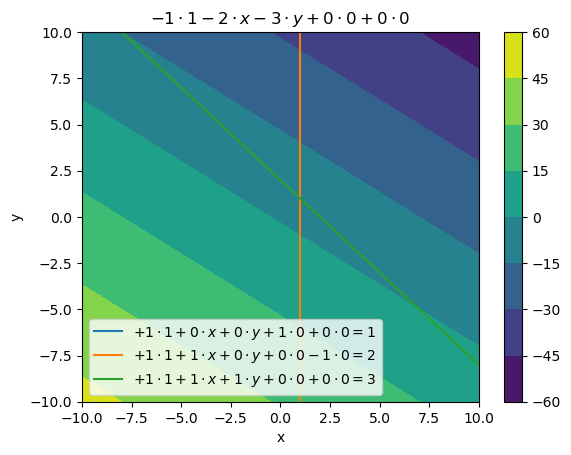

In [246]:
visualize_simplex_method_initial()

[-1, -2, 0, 0]
1
     x_1  x_2  x_3  x_4  b
x_1    1    0    1    0  1
x_2    1    1    0    1  2
     x_1  x_2  x_3  x_4  b
x_1    1    0    1    0  1
x_2    1    1    0    1  2
z      1    2    0    0  0
     x_1  x_2  x_3  x_4  x_5  x_6  b
x_1    1    0    1    0    1    0  1
x_2    1    1    0    1    0    1  2
     x_1  x_2  x_3  x_4  x_5  x_6    b
x_1  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_2  1.0  1.0  0.0  1.0  0.0  1.0  2.0
z   -0.0 -0.0 -0.0 -0.0 -1.0 -1.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_1  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_2  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
gauss
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z    0.0  0.0  2.0  1.0  1.0  1.0  3.0
simplex
x_5->x_1
k=0
j=2
     x_5  x_6  x_1  x_2  x_3

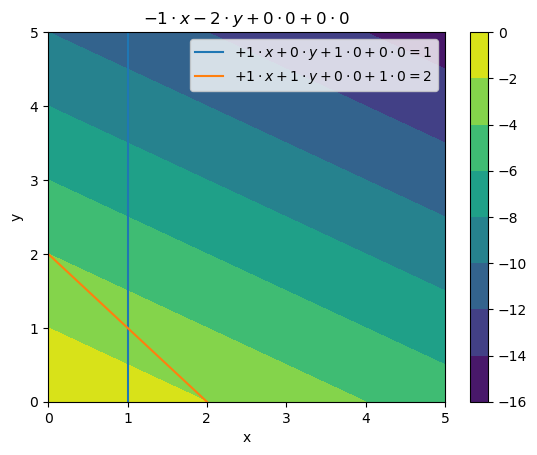

In [247]:
visualize_simplex_method_simple()

[-1, -2, 0, 0]
1
     x_1  x_2  x_3  x_4  b
x_1    1    0   -1    0  1
x_2    1    1    0   -1  2
     x_1  x_2  x_3  x_4  b
x_1    1    0   -1    0  1
x_2    1    1    0   -1  2
z      1    2    0    0  0
     x_1  x_2  x_3  x_4  x_5  x_6  b
x_1    1    0   -1    0    1    0  1
x_2    1    1    0   -1    0    1  2
     x_1  x_2  x_3  x_4  x_5  x_6    b
x_1  1.0  0.0 -1.0  0.0  1.0  0.0  1.0
x_2  1.0  1.0  0.0 -1.0  0.0  1.0  2.0
z   -0.0 -0.0 -0.0 -0.0 -1.0 -1.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_1  1.0  0.0  1.0  0.0 -1.0  0.0  1.0
x_2  0.0  1.0  1.0  1.0  0.0 -1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0 -1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0 -1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
gauss
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0 -1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0 -1.0  2.0
z    0.0  0.0  2.0  1.0 -1.0 -1.0  3.0
simplex
x_5->x_1
k=0
j=2
     x_5  x_6  x_1  x_2  x_3

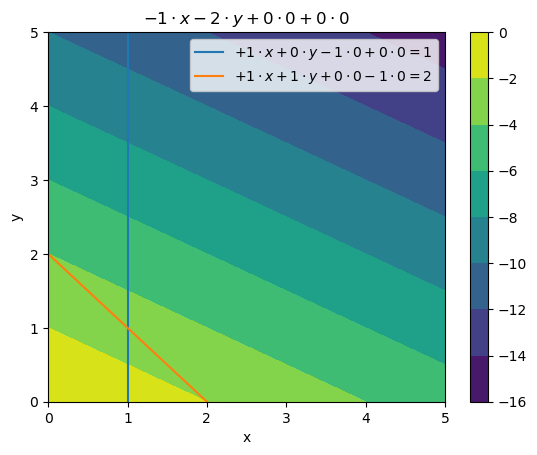

In [248]:
visualize_simplex_method_simple_no_solution()

[-1, -1, 0, 0]
1
     x_1  x_2  x_3  x_4  b
x_1    1    0    1    0  1
x_2    1    1    0    1  2
     x_1  x_2  x_3  x_4  b
x_1    1    0    1    0  1
x_2    1    1    0    1  2
z      1    1    0    0  0
     x_1  x_2  x_3  x_4  x_5  x_6  b
x_1    1    0    1    0    1    0  1
x_2    1    1    0    1    0    1  2
     x_1  x_2  x_3  x_4  x_5  x_6    b
x_1  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_2  1.0  1.0  0.0  1.0  0.0  1.0  2.0
z   -0.0 -0.0 -0.0 -0.0 -1.0 -1.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_1  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_2  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
gauss
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z    0.0  0.0  2.0  1.0  1.0  1.0  3.0
simplex
x_5->x_1
k=0
j=2
     x_5  x_6  x_1  x_2  x_3

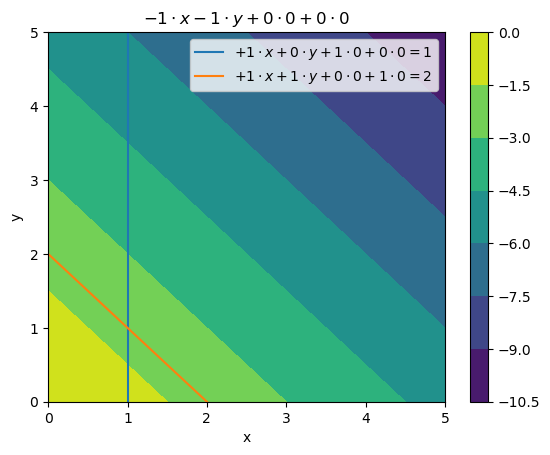

In [249]:
visualize_simplex_method_simple_parallel()

[-1, -2, 0, 0]
1
     x_1  x_2  x_3  x_4  b
x_1    1    0    1    0  1
x_2    1    1    0    1  2
     x_1  x_2  x_3  x_4  b
x_1    1    0    1    0  1
x_2    1    1    0    1  2
z      1    2    0    0  0
     x_1  x_2  x_3  x_4  x_5  x_6  b
x_1    1    0    1    0    1    0  1
x_2    1    1    0    1    0    1  2
     x_1  x_2  x_3  x_4  x_5  x_6    b
x_1  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_2  1.0  1.0  0.0  1.0  0.0  1.0  2.0
z   -0.0 -0.0 -0.0 -0.0 -1.0 -1.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_1  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_2  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z   -1.0 -1.0 -0.0 -0.0 -0.0 -0.0  0.0
gauss
     x_5  x_6  x_1  x_2  x_3  x_4    b
x_5  1.0  0.0  1.0  0.0  1.0  0.0  1.0
x_6  0.0  1.0  1.0  1.0  0.0  1.0  2.0
z    0.0  0.0  2.0  1.0  1.0  1.0  3.0
simplex
x_5->x_1
k=0
j=2
     x_5  x_6  x_1  x_2  x_3

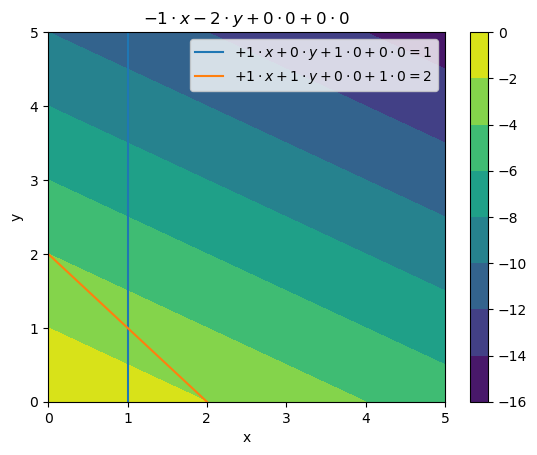

In [250]:
visualize_simplex_method_simple()
# f = x1 + 2x2+ 3x3 = x1+ 2x2 + 9-3x1-3x2=
#   = -2x1 - x2 + 9 -> max
#  

#### 5
Consider that the problem may have no solutions at all,
and have an infinite number of solutions.


Considered

#### 6
Implement sequential output of simplex tables at all steps of the algorithm.

Implemented